In [112]:
## Packages
# system
import os
# data wrangling
import numpy as np
import pandas as pd
from scipy import stats
from dfply import *
import statistics
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Settings
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', 1000)

### Data Import

In [113]:
%%time
## read in data 
raw_path = os.path.join('../../../', 'raw_data/')
processed_path = os.path.join('../', 'processed_data/')
# bene = pd.read_csv(os.path.join(raw_path, 'Train_Beneficiarydata-1542865627584.csv'))
flag = pd.read_csv(os.path.join(raw_path, 'Train-1542865627584.csv'))
df_ip = pd.read_csv(os.path.join(processed_path,'df_ip.csv'), index_col = 0)
df_op = pd.read_csv(os.path.join(processed_path,'df_op.csv'), index_col = 0)

CPU times: user 4.19 s, sys: 602 ms, total: 4.79 s
Wall time: 5.13 s


### Imputation

In [114]:
# check no code is currently 0
print(df_op[df_op.columns[df_op.columns.str.contains(pat = 'Cdoe')]].eq(0).any())

# fill NA codes with 0
code_col_op = df_op.columns[df_op.columns.str.contains(pat = 'Code')]
df_op[code_col_op] = df_op[code_col_op].fillna(0)

code_col_op = df_op.columns[df_op.columns.str.contains(pat = 'Code')]
df_op[code_col_op] = df_op[code_col_op].fillna(0)

Series([], dtype: bool)


In [115]:
code = df_op.columns[df_op.columns.str.contains('Code')]
diagnosiscode = df_op.columns[df_op.columns.str.contains('DiagnosisCode_')]
procedurecode = df_op.columns[df_op.columns.str.contains('ProcedureCode_')]
print('diagnosis code', len(diagnosiscode))
print('procedure code', len(procedurecode))

diagnosis code 10
procedure code 6


### Duplicated Claims

In [116]:
# duplicated claims
code_for_duplicate = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3','ClmDiagnosisCode_4',
                      'ClmProcedureCode_1', 'ClmProcedureCode_2', 
                      'ClmAdmitDiagnosisCode']

code_for_duplicate = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                      'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
                      'ClmProcedureCode_1', 'ClmAdmitDiagnosisCode']


# keep = first will mark all duplicates except the 1st occurrence
df_op_duplicate = df_op.duplicated(subset = code_for_duplicate, keep=False).sum()
print('outpatient claims', df_op.shape[0], 'duplicate #', df_op_duplicate, round(df_op_duplicate/df_op.shape[0], ndigits = 3))

df_op_duplicate = df_op.duplicated(subset = code_for_duplicate, keep=False).sum()
print('outpatient claims', df_op.shape[0], 'duplicate #', df_op_duplicate, round(df_op_duplicate/df_op.shape[0], ndigits = 3))

outpatient claims 517737 duplicate # 229202 0.443
outpatient claims 517737 duplicate # 229202 0.443


In [117]:
# duplicate claim dataframe
dup_op = df_op[df_op.duplicated(subset = code_for_duplicate, keep=False)]
# dup_op = df_op[df_op.duplicated(subset = code_for_duplicate, keep=False)].sort_values(by = 'ClmDiagnosisCode_1')
dup_op['group'] = dup_op.groupby(code_for_duplicate).grouper.group_info[0] + 1
display(dup_op.group.head())
display(dup_op.groupby('group').size().value_counts())

<ipython-input-117-216ac8d8fdbc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup_op['group'] = dup_op.groupby(code_for_duplicate).grouper.group_info[0] + 1


1     14509
3      1536
7     15216
12     4745
16     4514
Name: group, dtype: int64

2       11102
3        3768
4        1901
5        1163
6         799
7         615
8         460
9         419
11        297
10        292
12        229
13        187
14        176
17        166
15        163
18        131
19        130
16        125
20        115
22         94
26         89
21         85
23         85
24         84
25         75
28         68
30         64
27         61
29         57
33         49
34         46
32         44
39         43
35         40
37         38
40         38
31         37
38         33
43         28
45         27
41         25
36         24
49         24
44         23
51         23
47         22
50         21
42         20
46         19
92         15
55         15
56         14
48         13
58         13
53         13
96         13
52         13
61         11
57         11
94         11
79         11
54         11
100        10
86         10
78          9
77          9
69          9
64          9
99          9
72          8
106         8
62    

In [118]:
# merge duplicated groups to df_op
dup_op_groups = dup_op.group.to_frame()
df_op = df_op.merge(dup_op_groups, how = 'left', right_index = True, left_index = True)
df_op.group = df_op.group.fillna(0)
# display(df_op.head())

# flag whether a row in duplicated or not
df_op['duplicated'] = np.where(df_op.group.eq(0), False, True)
df_op.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimDuration,TotalPaid,group,duplicated
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,56409,1936-09-01,NaN,2,1,0,39,280,12,12,1,1,1,1,1,1,1,1,1,1,1,0,0,30,50,Yes,0,30,0.0,False
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1922-07-01,NaN,1,1,0,39,270,12,12,0,0,1,1,1,1,0,0,0,0,1,0,0,1810,760,Yes,0,40,14509.0,True
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,71947,1922-07-01,NaN,1,1,0,39,270,12,12,0,0,1,1,1,1,0,0,0,0,1,0,0,1810,760,Yes,0,200,0.0,False
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1922-07-01,NaN,1,1,0,39,270,12,12,0,0,1,1,1,1,0,0,0,0,1,0,0,1810,760,Yes,0,20,1536.0,True
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,4280,2449,V854,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1922-07-01,NaN,1,1,0,39,270,12,12,0,0,1,1,1,1,0,0,0,0,1,0,0,1810,760,Yes,0,40,0.0,False


#### ratio of claim duplication

In [119]:
df_op.groupby('PotentialFraud').apply(lambda x: x[x.group > 0].count())

flag_claim = df_op.groupby('PotentialFraud').ClaimID.count()
flag_duplicated = df_op.groupby('PotentialFraud').apply(lambda x: x[x['duplicated'] == True].\
                                                        count())['duplicated']
display(flag_claim)
display(flag_duplicated)

dup_op_tally = pd.DataFrame({'total_claim': flag_claim, 'duplicated_claim': flag_duplicated})
dup_op_tally['duplicated_ratio'] = round(dup_op_tally.duplicated_claim / dup_op_tally.total_claim, ndigits=4)
display(dup_op_tally)

PotentialFraud
No     328343
Yes    189394
Name: ClaimID, dtype: int64

PotentialFraud
No     145434
Yes     83768
Name: duplicated, dtype: int64

,total_claim,duplicated_claim,duplicated_ratio
PotentialFraud,,,
No,328343,145434,0.4429
Yes,189394,83768,0.4423


####  ratio of providers with duplicated claims

In [120]:
dup_op_flag_num = pd.DataFrame(df_op.groupby(['PotentialFraud','Provider']).duplicated.sum())
display(dup_op_flag_num.groupby('PotentialFraud').duplicated.sum())

# number of providers with duplicated claims
a = dup_op_flag_num.groupby('PotentialFraud').apply(lambda x: x[x['duplicated']!=0].count())
display(a)
# number of providers by flag
b = df_op.groupby('PotentialFraud').Provider.nunique().to_frame()
display(b)
# merge to calculate ratio
c = a.merge(b, left_index=True, right_index=True)
c.columns = ['provider_with_dup_claims', 'unique_providers']
c['ratio_provider_with_dup_claim'] = c.iloc[:,0]/c.iloc[:,1]
c

PotentialFraud
No     145434.0
Yes     83768.0
Name: duplicated, dtype: float64

,duplicated
PotentialFraud,
No,4328
Yes,458


,Provider
PotentialFraud,
No,4550
Yes,462


,provider_with_dup_claims,unique_providers,ratio_provider_with_dup_claim
PotentialFraud,,,
No,4328,4550,0.951209
Yes,458,462,0.991342


### duplicated claims per provider

In [121]:
df_op_group = df_op.groupby('Provider')

In [122]:
group_provider_claim_num = df_op_group.group.count()
display(group_provider_claim_num.shape)
display(group_provider_claim_num.head(2))

group_provider_dup_claim_num = df_op_group.duplicated.sum()
display(group_provider_claim_num.shape)
display(group_provider_dup_claim_num.head(2))

provider_dup_claim_num = pd.concat([group_provider_claim_num, group_provider_dup_claim_num], axis = 1)
provider_dup_claim_num.columns = ['ClaimNum', 'DupClaimNum']
provider_dup_claim_num['DupClaimRatio'] = provider_dup_claim_num['DupClaimNum'] / provider_dup_claim_num['ClaimNum']
provider_dup_claim_num['DupClaim'] = np.where(provider_dup_claim_num['DupClaimNum'] == 0, 'no', 'yes')
display(provider_dup_claim_num.shape)
display(provider_dup_claim_num.head())
provider_dup_claim_num.DupClaim.value_counts()

(5012,)

Provider
PRV51001    20
PRV51003    70
Name: group, dtype: int64

(5012,)

Provider
PRV51001    11.0
PRV51003    25.0
Name: duplicated, dtype: float64

(5012, 4)

,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim
Provider,,,,
PRV51001,20,11.0,0.550000,yes
PRV51003,70,25.0,0.357143,yes
PRV51004,149,72.0,0.483221,yes
PRV51005,1165,530.0,0.454936,yes
PRV51007,69,29.0,0.420290,yes


yes    4786
no      226
Name: DupClaim, dtype: int64

In [129]:
provider_dup_claim_num.to_csv('../output/op_dup_claim_per_provider.csv')
provider_dup_claim_num.index.nunique()

5012

#### duplicated claim per provider from another state

In [130]:
df_op_group = df_op.groupby('Provider')

In [131]:
# dup claims states by provider
dup_op_provider_state = dup_op[['group', 'PotentialFraud','Provider','State']].sort_values(by = 'group')
display(dup_op_provider_state.shape)
display(dup_op_provider_state.head())
# group by dup group
state_per_group = dup_op_provider_state.groupby('group').State.unique().reset_index()
display(state_per_group.shape)
display(state_per_group.head(3))
# get num of states by dup group
state_per_group2 = state_per_group.set_index('group').State.apply(lambda x: len(x)).\
                    to_frame().reset_index().rename(columns={"State":"num_of_states"})
display(state_per_group2.shape)
display(state_per_group2.head(3))
state_per_group2.num_of_states.value_counts()
# get dup groups per provider
state_per_group3 = dup_op_provider_state.groupby('Provider').group.unique().reset_index()
display(state_per_group3.shape)
display(state_per_group3.head(3))
# convert to dictionary
state_per_group_dict = state_per_group.set_index('group').T.to_dict()
display(state_per_group_dict[1])
display(state_per_group_dict[1]['State'].tolist())

(229202, 4)

,group,PotentialFraud,Provider,State
211010,1,No,PRV55177,34
145283,1,No,PRV56270,42
307140,1,No,PRV51468,5
33943,1,Yes,PRV54837,32
307185,1,No,PRV51468,5


(24303, 2)

,group,State
0,1,"[34, 42, 5, 32, 14, 1, 33, 26, 16, 4, 10, 31, ..."
1,2,"[51, 49, 34, 5, 39, 31, 37, 14, 52, 44, 10, 11..."
2,3,"[23, 26]"


(24303, 2)

,group,num_of_states
0,1,52
1,2,20
2,3,2


(4786, 2)

,Provider,group
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143..."
1,PRV51003,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482..."
2,PRV51004,"[1, 297, 1080, 1194, 2357, 2518, 2616, 3010, 3..."


{'State': array([34, 42,  5, 32, 14,  1, 33, 26, 16,  4, 10, 31, 52, 39, 23, 38,  7,
        54, 49, 22, 18, 45, 11, 25, 46, 19, 28, 50, 17,  3,  6, 44, 37, 24,
        21, 12, 15, 20, 47,  9, 36,  8, 51, 27, 29,  2, 53, 43, 41, 30, 13,
        35])}

[34,
 42,
 5,
 32,
 14,
 1,
 33,
 26,
 16,
 4,
 10,
 31,
 52,
 39,
 23,
 38,
 7,
 54,
 49,
 22,
 18,
 45,
 11,
 25,
 46,
 19,
 28,
 50,
 17,
 3,
 6,
 44,
 37,
 24,
 21,
 12,
 15,
 20,
 47,
 9,
 36,
 8,
 51,
 27,
 29,
 2,
 53,
 43,
 41,
 30,
 13,
 35]

In [132]:
def map_state_num(group_num_lst):
    ans = []
    lst = group_num_lst.tolist()
    for i in lst:
#         print('groups', i) # which dup claim groups belong to this Provider
#         print(type(i))
        new = state_per_group_dict[i]['State'].tolist() # states that the dup claims are from
#         print('new', new)
        ans.extend(new)
    ans = list(set(ans))
    return ans

k = map_state_num(state_per_group3.iloc[1,1])
k

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 50,
 51,
 52,
 53,
 54]

In [133]:
state_per_group3['DupClaimStates'] = state_per_group3.group.apply(map_state_num)
state_per_group3['DupClaimStatesNum'] = state_per_group3.DupClaimStates.apply(len)
state_per_group3['DupClaimMultiState'] = np.where(state_per_group3.DupClaimStatesNum <=1, 'no', 'yes')

In [134]:
state_per_group3.to_csv('../output/op_dup_claim_state_num_per_provider.csv')
display(state_per_group3.head(3))
display(state_per_group3.DupClaimMultiState.value_counts())
# display(state_per_group3.DupClaimStatesNum.value_counts())

,Provider,group,DupClaimStates,DupClaimStatesNum,DupClaimMultiState
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...",50,yes
1,PRV51003,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",52,yes
2,PRV51004,"[1, 297, 1080, 1194, 2357, 2518, 2616, 3010, 3...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",52,yes


yes    4785
no        1
Name: DupClaimMultiState, dtype: int64

In [135]:
# dup_claims_op = provider_dup_claim_num.reset_index().merge(state_per_group3, how='left', on='Provider')
# dup_claims_op.to_csv('../output/provider_table_op_dup_claims.csv')
# dup_claims_op.head(3)

#### duplicated claim per provider from another provider

In [136]:
df_op_group = df_op.groupby('Provider')

In [137]:
dup_op_provider_prv = dup_op[['group', 'PotentialFraud','Provider']].sort_values(by = 'group')
display(dup_op_provider_prv.shape)
display(dup_op_provider_prv.head())

(229202, 3)

,group,PotentialFraud,Provider
211010,1,No,PRV55177
145283,1,No,PRV56270
307140,1,No,PRV51468
33943,1,Yes,PRV54837
307185,1,No,PRV51468


In [138]:
# get unique provider by dup group
prv_per_group = dup_op_provider_prv.groupby('group').Provider.unique().reset_index()
display(prv_per_group.shape)
display(prv_per_group.head(3))
# get provider number by dup group
prv_per_group2 = prv_per_group.set_index('group').Provider.apply(lambda x: len(x)).\
                    to_frame().reset_index().rename(columns={"Provider":"ProviderNum"})
display(prv_per_group2.shape)
display(prv_per_group2.head(3))
prv_per_group2.ProviderNum.value_counts()
# per provider, get dup groups
prv_per_group3 = dup_op_provider_prv.groupby('Provider').group.unique().reset_index()
display(prv_per_group3.shape)
display(prv_per_group3.head(3))
# convert to dictionary
prv_per_group_dict = prv_per_group.set_index('group').T.to_dict()
prv_per_group_dict[1]

(24303, 2)

,group,Provider
0,1,"[PRV55177, PRV56270, PRV51468, PRV54837, PRV52..."
1,2,"[PRV57410, PRV55169, PRV55388, PRV51348, PRV56..."
2,3,"[PRV54049, PRV54472]"


(24303, 2)

,group,ProviderNum
0,1,2284
1,2,33
2,3,2


(4786, 2)

,Provider,group
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143..."
1,PRV51003,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482..."
2,PRV51004,"[1, 297, 1080, 1194, 2357, 2518, 2616, 3010, 3..."


{'Provider': array(['PRV55177', 'PRV56270', 'PRV51468', ..., 'PRV51281', 'PRV56656',
        'PRV52017'], dtype=object)}

In [139]:
def map_prv_num(group_num_lst):
    ans = []
    lst = group_num_lst.tolist()
    for i in lst:
#         print('groups', i) # which dup claim groups belong to this Provider
#         print(type(i))
        new = prv_per_group_dict[i]['Provider'].tolist() # states that the dup claims are from
#         print('new', new)
        ans.extend(new)
    ans = list(set(ans))
    return ans

k = map_prv_num(prv_per_group3.iloc[1,1])
k

['PRV51179',
 'PRV53992',
 'PRV56626',
 'PRV55247',
 'PRV53192',
 'PRV52148',
 'PRV52193',
 'PRV51173',
 'PRV51556',
 'PRV55059',
 'PRV56655',
 'PRV55001',
 'PRV52660',
 'PRV54937',
 'PRV51043',
 'PRV54971',
 'PRV51398',
 'PRV54036',
 'PRV55633',
 'PRV54074',
 'PRV51324',
 'PRV51611',
 'PRV55543',
 'PRV56606',
 'PRV52351',
 'PRV56368',
 'PRV54939',
 'PRV55295',
 'PRV51005',
 'PRV52609',
 'PRV57534',
 'PRV54333',
 'PRV52389',
 'PRV54111',
 'PRV57479',
 'PRV53477',
 'PRV53895',
 'PRV54778',
 'PRV51802',
 'PRV54879',
 'PRV55272',
 'PRV56733',
 'PRV57031',
 'PRV53388',
 'PRV57585',
 'PRV57671',
 'PRV52527',
 'PRV55238',
 'PRV55410',
 'PRV52241',
 'PRV54540',
 'PRV57172',
 'PRV55335',
 'PRV56887',
 'PRV51932',
 'PRV52045',
 'PRV52107',
 'PRV52367',
 'PRV57311',
 'PRV57715',
 'PRV54682',
 'PRV57475',
 'PRV53824',
 'PRV51266',
 'PRV53284',
 'PRV56725',
 'PRV51984',
 'PRV54216',
 'PRV56993',
 'PRV52587',
 'PRV53392',
 'PRV55869',
 'PRV57413',
 'PRV55503',
 'PRV54747',
 'PRV55701',
 'PRV55454',

In [190]:
prv_per_group3['DupClaimProvider'] = prv_per_group3.group.apply(map_prv_num)
prv_per_group3['DupClaimProviderNum'] = prv_per_group3.DupClaimProvider.apply(len)
prv_per_group3['DupClaimMultiProvider'] = np.where(prv_per_group3.DupClaimProviderNum <=1, 'no', 'yes')
prv_per_group3.head()

,Provider,group,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[PRV54651, PRV52104, PRV56976, PRV57686, PRV54...",422,yes
1,PRV51003,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482...","[PRV51179, PRV53992, PRV56626, PRV55247, PRV53...",1351,yes
2,PRV51004,"[1, 297, 1080, 1194, 2357, 2518, 2616, 3010, 3...","[PRV54790, PRV51958, PRV55179, PRV51179, PRV53...",3006,yes
3,PRV51005,"[1, 99, 221, 317, 391, 469, 645, 998, 1095, 10...","[PRV54790, PRV51958, PRV54416, PRV55179, PRV51...",3920,yes
4,PRV51007,"[657, 761, 945, 968, 1080, 2440, 2616, 4469, 7...","[PRV54790, PRV53992, PRV56088, PRV56626, PRV55...",1816,yes


In [191]:
prv_per_group3.to_csv('../output/op_dup_claim_prv_num_per_provider.csv')
display(prv_per_group3[prv_per_group3.DupClaimMultiProvider == 'no'].DupClaimProviderNum.sum())
display(prv_per_group3.head())
# prv_per_group3.DupClaimProviderNum.value_counts()

0

,Provider,group,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[PRV54651, PRV52104, PRV56976, PRV57686, PRV54...",422,yes
1,PRV51003,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482...","[PRV51179, PRV53992, PRV56626, PRV55247, PRV53...",1351,yes
2,PRV51004,"[1, 297, 1080, 1194, 2357, 2518, 2616, 3010, 3...","[PRV54790, PRV51958, PRV55179, PRV51179, PRV53...",3006,yes
3,PRV51005,"[1, 99, 221, 317, 391, 469, 645, 998, 1095, 10...","[PRV54790, PRV51958, PRV54416, PRV55179, PRV51...",3920,yes
4,PRV51007,"[657, 761, 945, 968, 1080, 2440, 2616, 4469, 7...","[PRV54790, PRV53992, PRV56088, PRV56626, PRV55...",1816,yes


In [142]:
# dup_claims_op = dup_claims_op.merge(prv_per_group3, how='left', on='Provider')
# dup_claims_op.to_csv('../processed_data/provider_table_op_dup_claims.csv')
# dup_claims_op.head(2)

#### duplicated claim per provider from another date

In [143]:
# dup_op_group = dup_op.groupby('Provider')
dup_op_provider_dt = dup_op[['group', 'PotentialFraud','Provider', 'ClaimStartDt']].sort_values(by = 'group')
display(dup_op_provider_dt.shape)
display(dup_op_provider_dt.head())

(229202, 4)

,group,PotentialFraud,Provider,ClaimStartDt
211010,1,No,PRV55177,2009-07-30
145283,1,No,PRV56270,2009-01-19
307140,1,No,PRV51468,2009-02-16
33943,1,Yes,PRV54837,2009-10-16
307185,1,No,PRV51468,2009-03-17


In [144]:
dt_per_group = dup_op_provider_dt.groupby('group').ClaimStartDt.unique().reset_index()
display(dt_per_group.shape)
display(dt_per_group.head(3))

dt_per_group2 = dt_per_group.set_index('group').ClaimStartDt.apply(lambda x: len(x)).\
                    to_frame().reset_index().rename(columns={"ClaimStartDt":"ClaimStartDtNum"})
display(dt_per_group2.shape)
display(dt_per_group2.head(3))
display(dt_per_group2.ClaimStartDtNum.value_counts())

dt_per_group3 = dup_op_provider_dt.groupby('Provider').group.unique().reset_index()
display(dt_per_group3.shape)
display(dt_per_group3.head(5))

(24303, 2)

,group,ClaimStartDt
0,1,"[2009-07-30, 2009-01-19, 2009-02-16, 2009-10-1..."
1,2,"[2009-05-01, 2009-02-02, 2009-07-08, 2009-03-0..."
2,3,"[2009-02-03, 2009-10-14]"


(24303, 2)

,group,ClaimStartDtNum
0,1,371
1,2,33
2,3,2


2      11077
3       3776
4       1898
5       1165
6        816
7        613
8        450
9        418
10       304
11       287
12       229
14       201
13       188
17       151
15       150
18       140
16       140
20       121
19       117
21        98
23        97
22        86
24        83
27        81
26        78
25        76
28        65
33        50
29        50
1         50
32        50
31        45
37        45
34        44
30        43
36        39
39        37
38        37
42        34
35        30
43        27
41        26
40        26
45        24
47        24
48        23
46        21
49        18
52        16
54        15
53        15
50        14
92        14
79        14
89        13
51        13
81        12
77        12
71        12
90        12
66        12
44        12
88        11
83        11
86        11
72        10
64        10
65        10
69        10
55        10
91        10
78        10
57         9
105        9
101        9
96         9
95         9

(4786, 2)

,Provider,group
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143..."
1,PRV51003,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482..."
2,PRV51004,"[1, 297, 1080, 1194, 2357, 2518, 2616, 3010, 3..."
3,PRV51005,"[1, 99, 221, 317, 391, 469, 645, 998, 1095, 10..."
4,PRV51007,"[657, 761, 945, 968, 1080, 2440, 2616, 4469, 7..."


In [145]:
dt_per_group_dict = dt_per_group.set_index('group').T.to_dict()
display(dt_per_group_dict[1])
dt_per_group_dict[1]['ClaimStartDt'].tolist()

def map_dt_num(group_num_lst):
    ans = []
    lst = group_num_lst.tolist()
    for i in lst:
#         print('groups', i) # which dup claim groups belong to this Provider
#         print(type(i))
        new = dt_per_group_dict[i]['ClaimStartDt'].tolist() # states that the dup claims are from
#         print('new', new)
        ans.extend(new)
    ans = list(set(ans))
    return ans

k = map_dt_num(dt_per_group3.iloc[1,1])
k

{'ClaimStartDt': array(['2009-07-30', '2009-01-19', '2009-02-16', '2009-10-16',
        '2009-03-17', '2009-02-05', '2009-02-20', '2009-01-08',
        '2009-09-10', '2009-04-14', '2009-03-18', '2009-09-20',
        '2009-09-24', '2009-04-17', '2009-07-31', '2009-11-21',
        '2009-10-20', '2009-04-23', '2009-10-12', '2009-04-19',
        '2009-07-18', '2009-06-21', '2009-08-19', '2009-07-24',
        '2009-06-25', '2009-11-29', '2009-12-30', '2009-10-31',
        '2009-10-18', '2009-04-24', '2009-09-03', '2009-03-07',
        '2009-04-11', '2009-12-01', '2009-10-14', '2009-08-28',
        '2009-10-25', '2009-04-20', '2009-08-21', '2009-04-28',
        '2009-07-01', '2009-05-19', '2009-06-14', '2009-05-25',
        '2009-05-15', '2009-01-18', '2009-08-10', '2009-12-31',
        '2009-01-06', '2009-10-07', '2009-01-13', '2009-06-19',
        '2009-03-08', '2009-02-12', '2009-08-23', '2009-10-04',
        '2009-10-09', '2009-04-10', '2009-02-06', '2009-02-24',
        '2009-03-27', '2

['2009-02-11',
 '2009-07-31',
 '2008-12-25',
 '2009-05-06',
 '2009-03-18',
 '2009-11-21',
 '2009-10-20',
 '2009-03-23',
 '2009-09-19',
 '2009-12-07',
 '2009-12-02',
 '2009-02-15',
 '2009-12-04',
 '2009-05-12',
 '2009-11-11',
 '2009-12-01',
 '2009-09-30',
 '2009-11-04',
 '2009-06-08',
 '2009-10-28',
 '2009-07-09',
 '2009-05-15',
 '2009-10-12',
 '2009-03-15',
 '2009-03-30',
 '2009-01-23',
 '2009-11-28',
 '2009-05-29',
 '2009-08-04',
 '2009-07-15',
 '2009-10-05',
 '2009-03-06',
 '2009-03-25',
 '2009-08-17',
 '2009-06-15',
 '2009-04-30',
 '2009-01-12',
 '2009-11-16',
 '2009-07-10',
 '2009-05-07',
 '2009-12-06',
 '2009-06-17',
 '2009-01-26',
 '2009-07-24',
 '2009-12-27',
 '2009-04-01',
 '2009-02-07',
 '2009-03-01',
 '2009-01-31',
 '2009-02-27',
 '2009-09-28',
 '2009-04-25',
 '2009-04-20',
 '2009-08-06',
 '2009-08-12',
 '2009-12-17',
 '2009-07-27',
 '2009-07-25',
 '2009-10-31',
 '2009-06-28',
 '2009-02-06',
 '2009-08-09',
 '2009-01-11',
 '2009-08-25',
 '2009-09-06',
 '2009-02-09',
 '2009-08-

In [146]:
dt_per_group3['DupClaimStartDt'] = dt_per_group3.group.apply(map_dt_num)
dt_per_group3['DupClaimStartDtNum'] = dt_per_group3.DupClaimStartDt.apply(len)
dt_per_group3['DupClaimMultiStartDt'] = np.where(dt_per_group3.DupClaimStartDtNum <=1, 'no', 'yes')

In [147]:
display(dt_per_group3.head())
# display(dt_per_group3.DupClaimStartDtNum.value_counts())

,Provider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[2009-01-15, 2009-09-26, 2009-07-13, 2009-12-1...",278,yes
1,PRV51003,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482...","[2009-02-11, 2009-07-31, 2008-12-25, 2009-05-0...",372,yes
2,PRV51004,"[1, 297, 1080, 1194, 2357, 2518, 2616, 3010, 3...","[2009-02-11, 2009-07-31, 2008-12-25, 2009-03-1...",375,yes
3,PRV51005,"[1, 99, 221, 317, 391, 469, 645, 998, 1095, 10...","[2009-02-11, 2009-07-31, 2008-12-25, 2009-03-1...",382,yes
4,PRV51007,"[657, 761, 945, 968, 1080, 2440, 2616, 4469, 7...","[2009-02-11, 2009-07-31, 2009-05-06, 2009-03-1...",371,yes


### Data Export

In [148]:
display(provider_dup_claim_num.shape)
display(provider_dup_claim_num.head(1))
display(state_per_group3.shape)
display(state_per_group3.head(1))
display(prv_per_group3.shape)
display(prv_per_group3.head(1))
display(dt_per_group3.shape)
display(dt_per_group3.head(1))

(5012, 4)

,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim
Provider,,,,
PRV51001,20,11.0,0.55,yes


(4786, 5)

,Provider,group,DupClaimStates,DupClaimStatesNum,DupClaimMultiState
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...",50,yes


(4786, 5)

,Provider,group,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[PRV54651, PRV52104, PRV56976, PRV57686, PRV54...",422,yes


(4786, 5)

,Provider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51001,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[2009-01-15, 2009-09-26, 2009-07-13, 2009-12-1...",278,yes


In [194]:
del dup_claims_op

In [195]:
dup_claims_op0 = state_per_group3.merge(prv_per_group3, how='inner', on='Provider')
dup_claims_op = dup_claims_op0.merge(dt_per_group3, how='inner', on='Provider')
dup_claims_op.drop(['group_x','group_y'], axis=1, inplace=True)

In [196]:
display(df_op.shape)
display(df_op.Provider.nunique())
display(dup_claims_op.shape)
dup_claims_op.head(2)

(517737, 56)

5012

(4786, 11)

,Provider,DupClaimStates,DupClaimStatesNum,DupClaimMultiState,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51001,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...",50,yes,"[PRV54651, PRV52104, PRV56976, PRV57686, PRV54...",422,yes,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[2009-01-15, 2009-09-26, 2009-07-13, 2009-12-1...",278,yes
1,PRV51003,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",52,yes,"[PRV51179, PRV53992, PRV56626, PRV55247, PRV53...",1351,yes,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482...","[2009-02-11, 2009-07-31, 2008-12-25, 2009-05-0...",372,yes


In [197]:
display(provider_dup_claim_num.shape)
provider_dup_claim_num.reset_index().head(3)

(5012, 4)

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim
0,PRV51001,20,11.0,0.550000,yes
1,PRV51003,70,25.0,0.357143,yes
2,PRV51004,149,72.0,0.483221,yes


In [198]:
provider_dup_op = provider_dup_claim_num.reset_index().merge(dup_claims_op, how='left', on='Provider')
display(provider_dup_op.shape)
display(provider_dup_op.head(2))

(5012, 15)

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim,DupClaimStates,DupClaimStatesNum,DupClaimMultiState,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51001,20,11.0,0.550000,yes,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...",50.0,yes,"[PRV54651, PRV52104, PRV56976, PRV57686, PRV54...",422.0,yes,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[2009-01-15, 2009-09-26, 2009-07-13, 2009-12-1...",278.0,yes
1,PRV51003,70,25.0,0.357143,yes,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",52.0,yes,"[PRV51179, PRV53992, PRV56626, PRV55247, PRV53...",1351.0,yes,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482...","[2009-02-11, 2009-07-31, 2008-12-25, 2009-05-0...",372.0,yes


In [199]:
provider_dup_op.to_csv('../processed_data/provider_dup_op.csv', index = False)
display(df_op.Provider.nunique())
display(provider_dup_op.shape)

5012

(5012, 15)

## Data Combination

In [200]:
provider_dup_ip = pd.read_csv('../processed_data/provider_dup_ip.csv', )

In [201]:
provider_dup_ip.head(2)

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim,DupClaimStates,DupClaimStatesNum,DupClaimMultiState,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51001,5,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PRV51003,62,1.0,0.016129,yes,"[1, 31]",2.0,yes,"['PRV51003', 'PRV54757']",2.0,yes,[593],"['2009-08-25', '2009-05-25']",2.0,yes


In [202]:
provider_dup0 = provider_dup_ip.merge(provider_dup_op, on='Provider', how='outer', suffixes=('_IP', '_OP'))

In [203]:
display(flag.shape)
display(provider_dup0.shape)
provider_dup0.head(2)

(5410, 2)

(5410, 29)

,Provider,ClaimNum_IP,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStates_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProvider_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,group_IP,DupClaimStartDt_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,ClaimNum_OP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStates_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProvider_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,group_OP,DupClaimStartDt_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP
0,PRV51001,5.0,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,11.0,0.550000,yes,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...",50.0,yes,"[PRV54651, PRV52104, PRV56976, PRV57686, PRV54...",422.0,yes,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[2009-01-15, 2009-09-26, 2009-07-13, 2009-12-1...",278.0,yes
1,PRV51003,62.0,1.0,0.016129,yes,"[1, 31]",2.0,yes,"['PRV51003', 'PRV54757']",2.0,yes,[593],"['2009-08-25', '2009-05-25']",2.0,yes,70.0,25.0,0.357143,yes,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",52.0,yes,"[PRV51179, PRV53992, PRV56626, PRV55247, PRV53...",1351.0,yes,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482...","[2009-02-11, 2009-07-31, 2008-12-25, 2009-05-0...",372.0,yes


In [204]:
provider_dup0.columns

Index(['Provider', 'ClaimNum_IP', 'DupClaimNum_IP', 'DupClaimRatio_IP', 'DupClaim_IP', 'DupClaimStates_IP', 'DupClaimStatesNum_IP', 'DupClaimMultiState_IP', 'DupClaimProvider_IP', 'DupClaimProviderNum_IP', 'DupClaimMultiProvider_IP', 'group_IP', 'DupClaimStartDt_IP', 'DupClaimStartDtNum_IP', 'DupClaimMultiStartDt_IP', 'ClaimNum_OP', 'DupClaimNum_OP', 'DupClaimRatio_OP', 'DupClaim_OP', 'DupClaimStates_OP', 'DupClaimStatesNum_OP', 'DupClaimMultiState_OP', 'DupClaimProvider_OP', 'DupClaimProviderNum_OP', 'DupClaimMultiProvider_OP', 'group_OP', 'DupClaimStartDt_OP', 'DupClaimStartDtNum_OP', 'DupClaimMultiStartDt_OP'], dtype='object')

In [205]:
provider_dup_ip.columns == provider_dup_op.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [208]:
# del provider_dup

In [209]:
provider_dup = flag.merge(provider_dup0, on = 'Provider', how='left')

In [210]:
provider_dup.head(2)

,Provider,PotentialFraud,ClaimNum_IP,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStates_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProvider_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,group_IP,DupClaimStartDt_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,ClaimNum_OP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStates_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProvider_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,group_OP,DupClaimStartDt_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP
0,PRV51001,No,5.0,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,11.0,0.550000,yes,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...",50.0,yes,"[PRV54651, PRV52104, PRV56976, PRV57686, PRV54...",422.0,yes,"[91, 369, 2371, 3943, 11023, 11715, 12475, 143...","[2009-01-15, 2009-09-26, 2009-07-13, 2009-12-1...",278.0,yes
1,PRV51003,Yes,62.0,1.0,0.016129,yes,"[1, 31]",2.0,yes,"['PRV51003', 'PRV54757']",2.0,yes,[593],"['2009-08-25', '2009-05-25']",2.0,yes,70.0,25.0,0.357143,yes,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",52.0,yes,"[PRV51179, PRV53992, PRV56626, PRV55247, PRV53...",1351.0,yes,"[1194, 2318, 3010, 3281, 3563, 4514, 4823, 482...","[2009-02-11, 2009-07-31, 2008-12-25, 2009-05-0...",372.0,yes


In [213]:
## impute NA
provider_dup.ClaimNum_IP = provider_dup.ClaimNum_IP.fillna(0)
provider_dup.ClaimNum_OP = provider_dup.ClaimNum_OP.fillna(0)
provider_dup.DupClaimNum_IP = provider_dup.DupClaim_IP.fillna(0)
provider_dup.DupClaimNum_OP = provider_dup.DupClaim_OP.fillna(0)
provider_dup.DupClaimRatio_IP = provider_dup.DupClaimRatio_IP.fillna(0)
provider_dup.DupClaimRatio_OP = provider_dup.DupClaimRatio_OP.fillna(0)
provider_dup.DupClaim_IP = provider_dup.DupClaim_IP.fillna('none')
provider_dup.DupClaim_OP = provider_dup.DupClaim_OP.fillna('none')

provider_dup.DupClaimStatesNum_IP = provider_dup.DupClaimStatesNum_IP.fillna(0)
provider_dup.DupClaimStatesNum_OP = provider_dup.DupClaimStatesNum_OP.fillna(0)
provider_dup.DupClaimMultiState_IP = provider_dup.DupClaimMultiState_IP.fillna('none')
provider_dup.DupClaimMultiState_OP = provider_dup.DupClaimMultiState_OP.fillna('none')

provider_dup.DupClaimProviderNum_IP = provider_dup.DupClaimProviderNum_IP.fillna(0)
provider_dup.DupClaimProviderNum_OP = provider_dup.DupClaimProviderNum_OP.fillna(0)
provider_dup.DupClaimMultiProvider_IP = provider_dup.DupClaimMultiProvider_IP.fillna('none')
provider_dup.DupClaimMultiProvider_OP = provider_dup.DupClaimMultiProvider_OP.fillna('none')

provider_dup.DupClaimStartDtNum_IP = provider_dup.DupClaimStartDtNum_IP.fillna(0)
provider_dup.DupClaimStartDtNum_OP = provider_dup.DupClaimStartDtNum_OP.fillna(0)
provider_dup.DupClaimMultiStartDt_IP = provider_dup.DupClaimMultiStartDt_IP.fillna('none')
provider_dup.DupClaimMultiStartDt_OP = provider_dup.DupClaimMultiStartDt_OP.fillna('none')

In [214]:
provider_dup.to_csv('../processed_data/provider_dup.csv', index=False)

In [215]:
provider_dup_short = provider_dup.drop(['ClaimNum_IP','DupClaimStates_IP','DupClaimProvider_IP',
                                        'DupClaimStartDt_IP','group_IP',
                                        'ClaimNum_OP','DupClaimStates_OP','DupClaimProvider_OP', 
                                        'DupClaimStartDt_OP','group_OP' ], axis=1)

In [216]:
display(provider_dup_short.shape)
provider_dup_short.head(2)

(5410, 20)

,Provider,PotentialFraud,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP
0,PRV51001,No,no,0.000000,no,0.0,none,0.0,none,0.0,none,yes,0.550000,yes,50.0,yes,422.0,yes,278.0,yes
1,PRV51003,Yes,yes,0.016129,yes,2.0,yes,2.0,yes,2.0,yes,yes,0.357143,yes,52.0,yes,1351.0,yes,372.0,yes


In [217]:
pd.isna(provider_dup_short).sum()

Provider                    0
PotentialFraud              0
DupClaimNum_IP              0
DupClaimRatio_IP            0
DupClaim_IP                 0
DupClaimStatesNum_IP        0
DupClaimMultiState_IP       0
DupClaimProviderNum_IP      0
DupClaimMultiProvider_IP    0
DupClaimStartDtNum_IP       0
DupClaimMultiStartDt_IP     0
DupClaimNum_OP              0
DupClaimRatio_OP            0
DupClaim_OP                 0
DupClaimStatesNum_OP        0
DupClaimMultiState_OP       0
DupClaimProviderNum_OP      0
DupClaimMultiProvider_OP    0
DupClaimStartDtNum_OP       0
DupClaimMultiStartDt_OP     0
dtype: int64

In [218]:
provider_dup_short[pd.isna(provider_dup_short.DupClaimNum_IP)].shape

(0, 20)

In [219]:
provider_dup_short[pd.isna(provider_dup_short.DupClaimNum_OP)].shape

(0, 20)

In [221]:
flag.shape[0]

5410

In [222]:
provider_dup_short.to_csv('../processed_data/provider_dup_short.csv', index=False)

### Feature Distinguishing Power

In [54]:
provider_dup_short.head(2)

,Provider,PotentialFraud,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP
0,PRV51001,No,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.550000,yes,50.0,yes,422.0,yes,278.0,yes
1,PRV51003,Yes,1.0,0.016129,yes,2.0,yes,2.0,yes,2.0,yes,25.0,0.357143,yes,52.0,yes,1351.0,yes,372.0,yes


In [59]:
df_ip.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumato

In [66]:
provider_dup_short[provider_dup_short['DupClaimRatio_IP'] == 'Yes']

,Provider,PotentialFraud,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP


In [76]:
import seaborn as sns

Text(0.5, 1.0, 'DupClaimRatio')

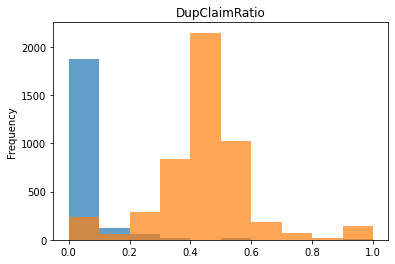

In [94]:
provider_dup_short.DupClaimRatio_IP.plot.hist(alpha = 0.7)
provider_dup_short.DupClaimRatio_OP.plot.hist(alpha = 0.7)
plt.title('DupClaimRatio')

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


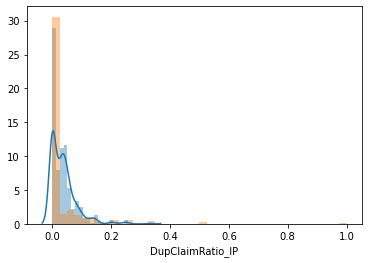

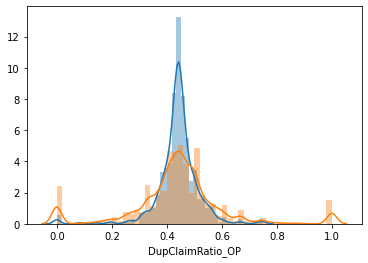

In [79]:
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'Yes'].DupClaimRatio_IP)
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'No'].DupClaimRatio_IP)
plt.title('IP')
plt.show()

sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'Yes'].DupClaimRatio_OP)
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'No'].DupClaimRatio_OP)

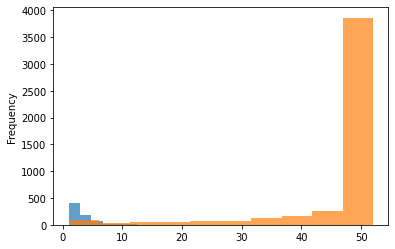

In [91]:
provider_dup_short.DupClaimStatesNum_IP.plot.hist(alpha = 0.7)
provider_dup_short.DupClaimStatesNum_OP.plot.hist(alpha = 0.7)

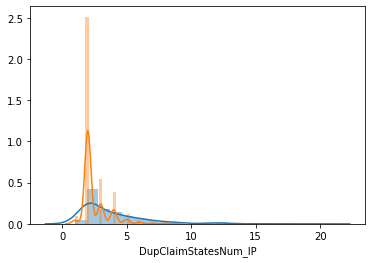

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


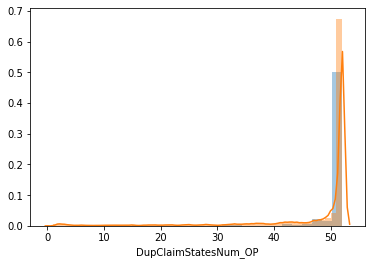

In [80]:
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'Yes'].DupClaimStatesNum_IP)
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'No'].DupClaimStatesNum_IP)
plt.title('IP')
plt.show()

sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'Yes'].DupClaimStatesNum_OP)
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'No'].DupClaimStatesNum_OP)
plt.show()

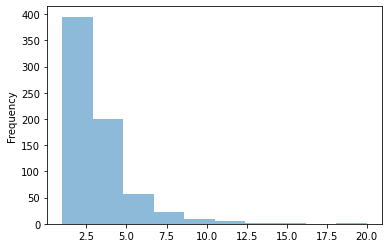

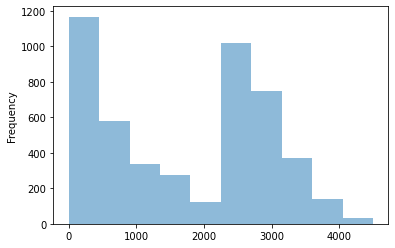

In [88]:
provider_dup_short.DupClaimProviderNum_IP.plot.hist(alpha = 0.5)
plt.show()
provider_dup_short.DupClaimProviderNum_OP.plot.hist(alpha = 0.5)

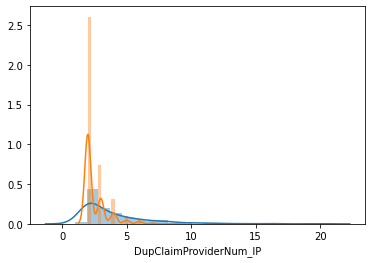

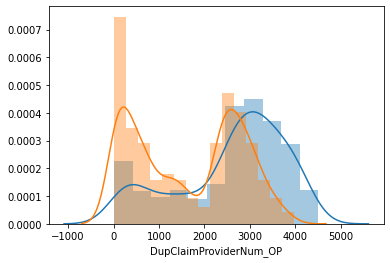

In [81]:
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'Yes'].DupClaimProviderNum_IP)
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'No'].DupClaimProviderNum_IP)
plt.show()

sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'Yes'].DupClaimProviderNum_OP)
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'No'].DupClaimProviderNum_OP)
plt.show()

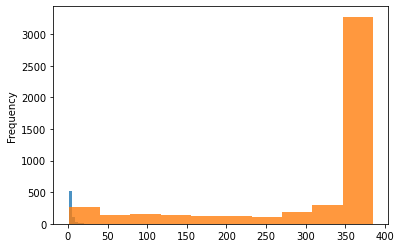

In [90]:
provider_dup_short.DupClaimStartDtNum_IP.plot.hist(alpha = 0.8)
provider_dup_short.DupClaimStartDtNum_OP.plot.hist(alpha = 0.8)

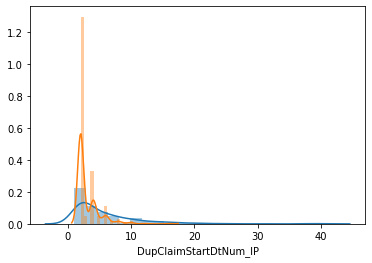

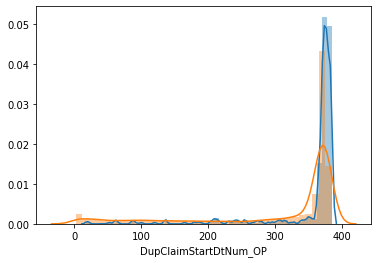

In [82]:
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'Yes'].DupClaimStartDtNum_IP)
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'No'].DupClaimStartDtNum_IP)
plt.show()

sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'Yes'].DupClaimStartDtNum_OP)
sns.distplot( provider_dup_short[provider_dup_short['PotentialFraud'] == 'No'].DupClaimStartDtNum_OP)
plt.show()